In [3]:
import os
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torchvision.__version__)
print(device)

1.12.0+cu116
0.13.0+cu116
cuda


In [4]:
# for download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Calculate the Normalization value for dataset
train_transform_norm = transforms.Compose([transforms.ToTensor()])
trainset_norm = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_norm)
data = trainset_norm.data
mean_value = tuple(data.mean(axis=(0,1,2))/255)
std_value = tuple(data.std(axis=(0,1,2))/255)
print(mean_value, std_value)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
(0.49139967861519607, 0.48215840839460783, 0.44653091444546567) (0.24703223246328176, 0.24348512800005648, 0.26158784172796473)


In [6]:
# define transform for cifar10
train_transform = transforms.Compose([
transforms.RandomCrop(32, padding=4),
transforms.RandomRotation((10,20)),
transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(mean_value, std_value),
])
test_transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean_value, std_value),
])

In [7]:
# load train and test data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

batch_size=32
train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
# build the resnet18 model
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, channel_in, channel_out, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_out)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_out)
        
        self.highway = nn.Sequential()
        if stride != 1 or channel_in != channel_out:
            self.highway = nn.Sequential(
                nn.Conv2d(channel_in, channel_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel_out)
            )
            
    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        output = output + self.highway(x)
        output = F.relu(output)
        return output
    

class ResNet(nn.Module):
    def __init__(self, ResidualBlock,channel_in=64,num_classes=10):
        super(ResNet, self).__init__()
        self.channel_in = channel_in
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=3, padding=1, bias=False),nn.BatchNorm2d(64),nn.ReLU())     
        self.conv2 = self.make_layer(ResidualBlock, 64, 2, 1)
        self.conv3 = self.make_layer(ResidualBlock, 128, 2, 2)
        self.conv4 = self.make_layer(ResidualBlock, 256, 2, 2)
        self.conv5 = self.make_layer(ResidualBlock, 512, 2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResidualBlock.expansion, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.channel_in, channels, stride))
            self.channel_in = channels * block.expansion
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

net = ResNet(ResidualBlock)
print(net)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (highway): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Bat

In [9]:
# train the resnet 18
train_acc_all = []
test_acc_all = []
loss_all = []
def train(net, train_iter,test_iter, batch_size, optimizer, device, num_epochs):
	net = net.to(device)
	print("The training device is: ", device)
	print("Model: resnet18")
	criterion = nn.CrossEntropyLoss()
	batch_count = 0 
	for epoch in range(num_epochs):
		loss_sum, train_acc_sum, n_train = 0.0, 0.0, 0
		for X, y in train_iter: 
			X = X.to(device) 
			y = y.to(device)
			y_hat = net(X) 
			loss = criterion(y_hat, y)
			optimizer.zero_grad()
			loss.backward() 
			optimizer.step() 
			loss_sum += loss.cpu().item() 
			train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
			n_train += y.shape[0] 
			batch_count += 1
			# print(batch_count)
		test_acc_sum, n_test = 0.0, 0
		with torch.no_grad():
			for X, y in test_iter:
				test_acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
				net.train()
				n_test += y.shape[0]
		train_acc_total = train_acc_sum / n_train
		test_acc_total = test_acc_sum / n_test
		loss_total = loss_sum / batch_count
		print('Epoch: %d, Loss: %.4f, Train accuracy %.3f, Test accuracy %.3f'
				% (epoch + 1, loss_total, train_acc_total, test_acc_total))
		train_acc_all.append(train_acc_total)
		test_acc_all.append(test_acc_total)
		loss_all.append(loss_total)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
train(net, train_iter,test_iter, batch_size, optimizer, device, 100)

The training device is:  cuda
Model: resnet18
Epoch: 1, Loss: 2.1521, Train accuracy 0.199, Test accuracy 0.307
Epoch: 2, Loss: 0.9049, Train accuracy 0.332, Test accuracy 0.373
Epoch: 3, Loss: 0.5442, Train accuracy 0.407, Test accuracy 0.442
Epoch: 4, Loss: 0.3771, Train accuracy 0.456, Test accuracy 0.486
Epoch: 5, Loss: 0.2799, Train accuracy 0.498, Test accuracy 0.529
Epoch: 6, Loss: 0.2193, Train accuracy 0.530, Test accuracy 0.560
Epoch: 7, Loss: 0.1765, Train accuracy 0.561, Test accuracy 0.563
Epoch: 8, Loss: 0.1475, Train accuracy 0.586, Test accuracy 0.602
Epoch: 9, Loss: 0.1251, Train accuracy 0.604, Test accuracy 0.612
Epoch: 10, Loss: 0.1082, Train accuracy 0.622, Test accuracy 0.630
Epoch: 11, Loss: 0.0948, Train accuracy 0.634, Test accuracy 0.639
Epoch: 12, Loss: 0.0838, Train accuracy 0.651, Test accuracy 0.650
Epoch: 13, Loss: 0.0749, Train accuracy 0.662, Test accuracy 0.652
Epoch: 14, Loss: 0.0677, Train accuracy 0.671, Test accuracy 0.648
Epoch: 15, Loss: 0.0611, 

KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), "project_resnet18_4.pth")

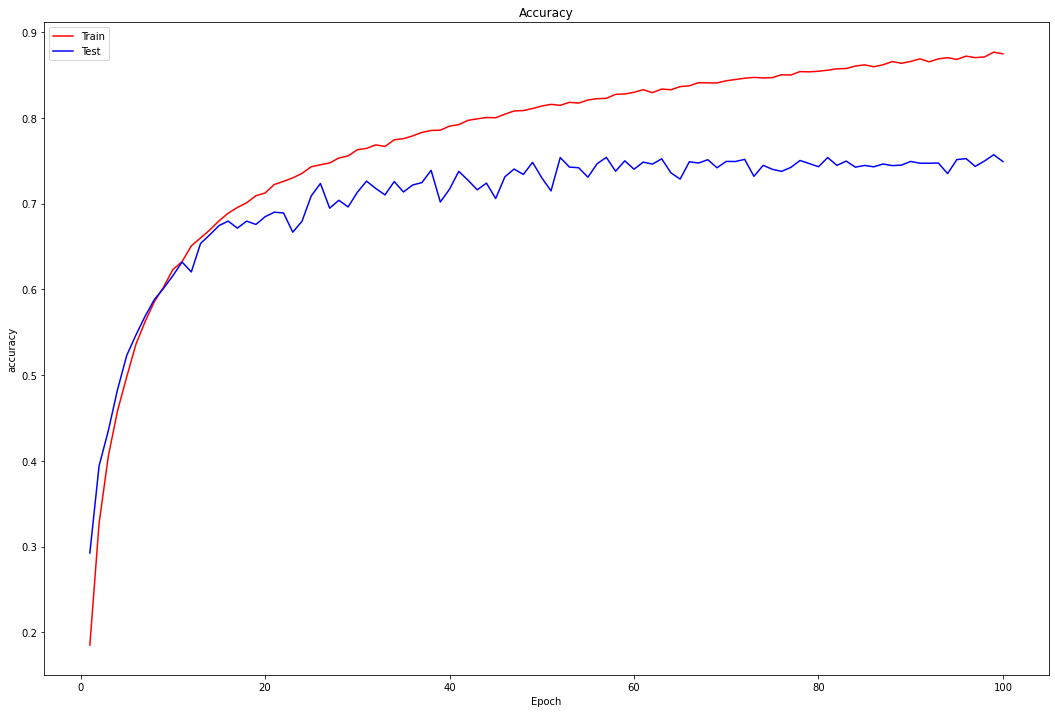

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, 100, 100)
plt.figure(figsize=(18,12))
plt.plot(x, train_acc_all,color = 'r')
plt.plot(x, test_acc_all, color = 'b')
plt.title('Accuracy')
plt.legend(['Train','Test'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.savefig('./e100acc_1.jpg')
plt.show()

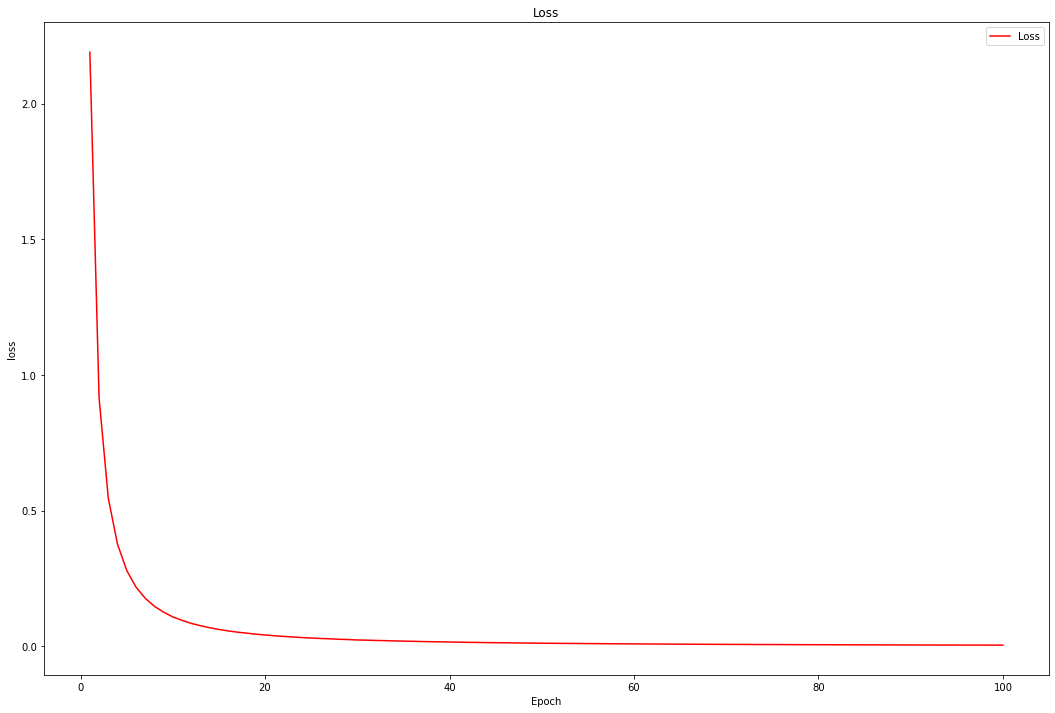

In [ ]:
x = np.linspace(1, 100, 100)
plt.figure(figsize=(18,12))
plt.plot(x, loss_all,color = 'r')
plt.title('Loss')
plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig('./e100loss_1.jpg')
plt.show()